# Descripción del proyecto

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos. Tu objetivo es entrenar un modelo para predecir si un cliente va abandonar el servicio. Para lograrlo, utilizarás los datos proporcionados por el deparatamento de marketing de la empresa. Al comprobar las metricas de evalucion el mejor modelo deberá alcanzar un valor AUROC de al menos 0.75.

# Plan Proyecto 

## Inicialización
En esta etapa se colocan todas las librerias que se van a importar para el desarrollo del proyecto.

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, precision_score, roc_auc_score, recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier


In [200]:
import os
os.makedirs("visualizaciones_churn_modelo", exist_ok=True)

In [176]:
pip install xgboost

## 2. Visualizacion de Datos

En la segunda etapa se va cargar todos los archivos desde la libreria pandas para poder visualizar que informacion tiene cada uno de los archivos para el desarrollo del proyecto.

In [93]:
# Cargar datasets
contrato = pd.read_csv('contract.csv')
personal = pd.read_csv('personal.csv')
internet = pd.read_csv('internet.csv')
phone = pd.read_csv('phone.csv')

In [94]:
#Mostrar informacion
def info_data(datos):
    print('Primeras Filas')
    print(datos.head())
    print('Informacion General')
    print(datos.info())
    print('Datos nulos')
    print(datos.isna().sum())
    print('Datos Duplicados')
    print(datos.duplicated().sum())

In [95]:
contrato

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [96]:
info_data(contrato)

Primeras Filas
   customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65  
Informacion General
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):


En el dataset con los datos del contrato se encuentra la columna EndDate es decir la fecha de cancelacion, No quiere decir que aun cuentan con el servicio y los usarios que tienen fecha son los que finalizaron el servicio, las columas categoricas se les va realizar codificacion One-Hot, y las columnas con datos numericos se va estandarizar. 

In [97]:
personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


En este dataset igual las columas que sean categoricas se va codificar con One-hot, la columna SeniorCitizen ya esta codificada, se va renombrar la columna gender a Gender.

In [98]:
personal.rename(columns={'gender': 'Gender'}, inplace=True)

In [99]:
info_data(personal)

Primeras Filas
   customerID  Gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No
Informacion General
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   Gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
Datos nulos
customerID       0
Gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64
Datos Duplicados
0


In [100]:
internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


En el dataset de Internet igual se va convertir las variables categoricas en numericas.

In [101]:
info_data(internet)

Primeras Filas
   customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No  
Informacion General
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-nu

In [102]:
phone

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [103]:
info_data(phone)

Primeras Filas
   customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes
Informacion General
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
Datos nulos
customerID       0
MultipleLines    0
dtype: int64
Datos Duplicados
0


En el dataset de phone ifual se va convertir variables numericas en categoricas

## DataWranling

En este caso ninguno de los datasets tiene datos duplicados o nulos, pero antes de unir todos los datasets por la columna ID, en el dataset de contrato la columna Total de Cargos se va convertir de tipo objeto a tipo flotante, para evitar errores,y la columna BeginDate convertirla en tipo fecha, se va crear la columna Churn de cancelacion para no afectar los datos de EndDate y luego se va trasnformar en tipo fecha. 

In [104]:
#Convierte la variable TotalCharge de objet a float
contrato['TotalCharges'] = pd.to_numeric(contrato['TotalCharges'], errors='coerce')

In [105]:
contrato['TotalCharges'].isna().sum()

11

In [106]:
# Al convertir la columna a datos flotantes los espacios se convirtieorn en datos nulos entonces se va rellenar con la media 
contrato['TotalCharges'] = contrato['TotalCharges'].fillna(contrato['TotalCharges'].mean())

In [107]:
#Comprobar datos nulos
contrato['TotalCharges'].isna().sum()

0

In [108]:
# Convertir la columan BeginDate en tipo de dato fecha
contrato['BeginDate'] = pd.to_datetime(contrato['BeginDate'], errors='coerce')

In [109]:
#Creacion de la columna Churn
contrato['Churn'] = contrato['EndDate'].apply(lambda x: 1 if x != 'No' else 0)

In [110]:
# Convertir la columna EndDate en tipo de dato fecha 
contrato['EndDate'] = contrato['EndDate'].replace('No', pd.NA)
contrato['EndDate'] = pd.to_datetime(contrato['EndDate'], errors='coerce')

In [111]:
#Crear un variable de duracion de contrato en meses para el entrenamiento del modelo 
contrato['fecha_fin'] = contrato['EndDate'].fillna(pd.Timestamp.today())

# Crear la variable duración (en meses)
contrato['duracion_meses'] = (contrato['fecha_fin'] - contrato['BeginDate']) / pd.Timedelta(days=30)
contrato['duracion_meses'] = contrato['duracion_meses'].round(0).astype(int)


In [112]:
contrato

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,fecha_fin,duracion_meses
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,0,2025-07-16 01:53:18.816745,67
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,0,2025-07-16 01:53:18.816745,101
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,2019-12-01 00:00:00.000000,2
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,0,2025-07-16 01:53:18.816745,112
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,2019-11-01 00:00:00.000000,2
...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,NaT,One year,Yes,Mailed check,84.80,1990.50,0,2025-07-16 01:53:18.816745,91
7039,2234-XADUH,2014-02-01,NaT,One year,Yes,Credit card (automatic),103.20,7362.90,0,2025-07-16 01:53:18.816745,139
7040,4801-JZAZL,2019-03-01,NaT,Month-to-month,Yes,Electronic check,29.60,346.45,0,2025-07-16 01:53:18.816745,78
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,1,2019-11-01 00:00:00.000000,4


In [113]:
contrato.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int64         
 9   fecha_fin         7043 non-null   datetime64[ns]
 10  duracion_meses    7043 non-null   int32         
dtypes: datetime64[ns](3), float64(2), int32(1), int64(1), object(4)
memory usage: 577.9+ KB


In [114]:
#Eliminar las variables que si se van usar para el entrenamiento del dataset contrato
df_simplificado = contrato.drop(['BeginDate','EndDate','fecha_fin'], axis=1)

In [115]:
df_simplificado

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,duracion_meses
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,67
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,101
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,2
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,112
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,2
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,One year,Yes,Mailed check,84.80,1990.50,0,91
7039,2234-XADUH,One year,Yes,Credit card (automatic),103.20,7362.90,0,139
7040,4801-JZAZL,Month-to-month,Yes,Electronic check,29.60,346.45,0,78
7041,8361-LTMKD,Month-to-month,Yes,Mailed check,74.40,306.60,1,4


In [116]:
## Primer paso: unir dataset de contrato y personal
data_1 = pd.merge(df_simplificado, personal, on='customerID', how='inner')
# Segundo paso: unir el resultado con dataset de internet 
data_2 = pd.merge(data_1, internet, on='customerID', how='inner')
# Tercer paso: unir el resultado con df4
df_final = pd.merge(data_2, phone, on='customerID', how='inner')

In [117]:
df_final

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,duracion_meses,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,101,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
1,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,2,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
2,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,2,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
3,9305-CDSKC,Month-to-month,Yes,Electronic check,99.65,820.50,1,8,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
4,1452-KIOVK,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,0,89,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,8456-QDAVC,Month-to-month,Yes,Bank transfer (automatic),78.70,1495.10,0,86,Male,0,No,No,Fiber optic,No,No,No,No,Yes,No,No
4831,6840-RESVB,One year,Yes,Mailed check,84.80,1990.50,0,91,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
4832,2234-XADUH,One year,Yes,Credit card (automatic),103.20,7362.90,0,139,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
4833,8361-LTMKD,Month-to-month,Yes,Mailed check,74.40,306.60,1,4,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


In [118]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        4835 non-null   object 
 1   Type              4835 non-null   object 
 2   PaperlessBilling  4835 non-null   object 
 3   PaymentMethod     4835 non-null   object 
 4   MonthlyCharges    4835 non-null   float64
 5   TotalCharges      4835 non-null   float64
 6   Churn             4835 non-null   int64  
 7   duracion_meses    4835 non-null   int32  
 8   Gender            4835 non-null   object 
 9   SeniorCitizen     4835 non-null   int64  
 10  Partner           4835 non-null   object 
 11  Dependents        4835 non-null   object 
 12  InternetService   4835 non-null   object 
 13  OnlineSecurity    4835 non-null   object 
 14  OnlineBackup      4835 non-null   object 
 15  DeviceProtection  4835 non-null   object 
 16  TechSupport       4835 non-null   object 


## EDA

In [119]:
## Visualizar cuantos clientes han cancelado y cuantos se mantienen 
tasa_de_cancelacion = contrato['Churn'].value_counts()

In [120]:
tasa_de_cancelacion

Churn
0    5174
1    1869
Name: count, dtype: int64

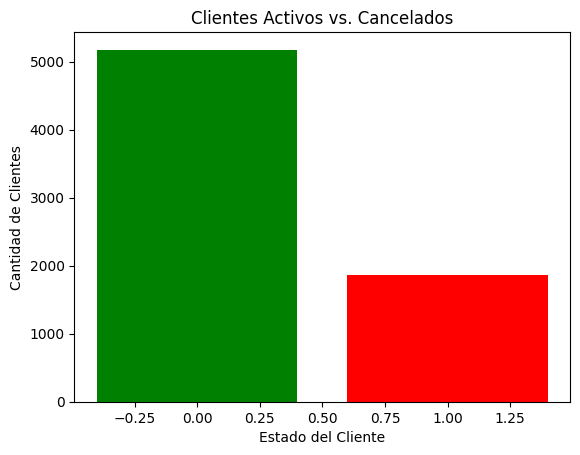

In [121]:
plt.bar(tasa_de_cancelacion.index, tasa_de_cancelacion.values, color=['green', 'red'])
plt.xlabel('Estado del Cliente')
plt.ylabel('Cantidad de Clientes')
plt.title('Clientes Activos vs. Cancelados')
plt.show()


### Observaciones
Segun la grafica podemos analizar que hay mas clientes que aun conservan el servicio que clientes que cancelaron, esto puede ocasionar un desbalanceo de clases y en el entrenamiento del  modelo va tener un mejor rendimiento en clientes que aun conservan el servicio que en predecir los que cancelan, entonces por esta razon seria adecuado hacer un balanceo de clases. 

In [122]:
print(df_final['Churn'].unique())
print(df_final['Churn'].dtype)

[0 1]
int64


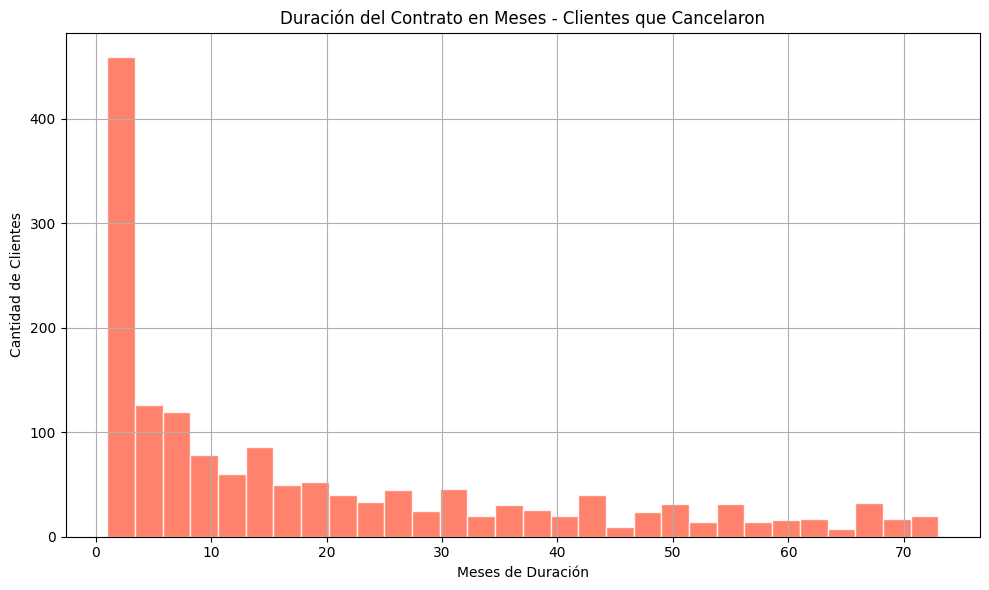

In [123]:
# Duracion en meses de los clientes que cancelaron 
cancelados = df_final[df_final['Churn'] == 1]

# Graficar histograma de duración
plt.figure(figsize=(10, 6))
plt.hist(cancelados['duracion_meses'], bins=30, color='tomato', edgecolor='white', alpha=0.8)

# Etiquetas
plt.title('Duración del Contrato en Meses - Clientes que Cancelaron')
plt.xlabel('Meses de Duración')
plt.ylabel('Cantidad de Clientes')
plt.grid(True)
plt.tight_layout()
plt.show()


### Observaciones
Los clientes que cancelaron el servicio en su mayoria no duraron ni dos meses son pocos los que mantenian meses de contrato con la empresa.

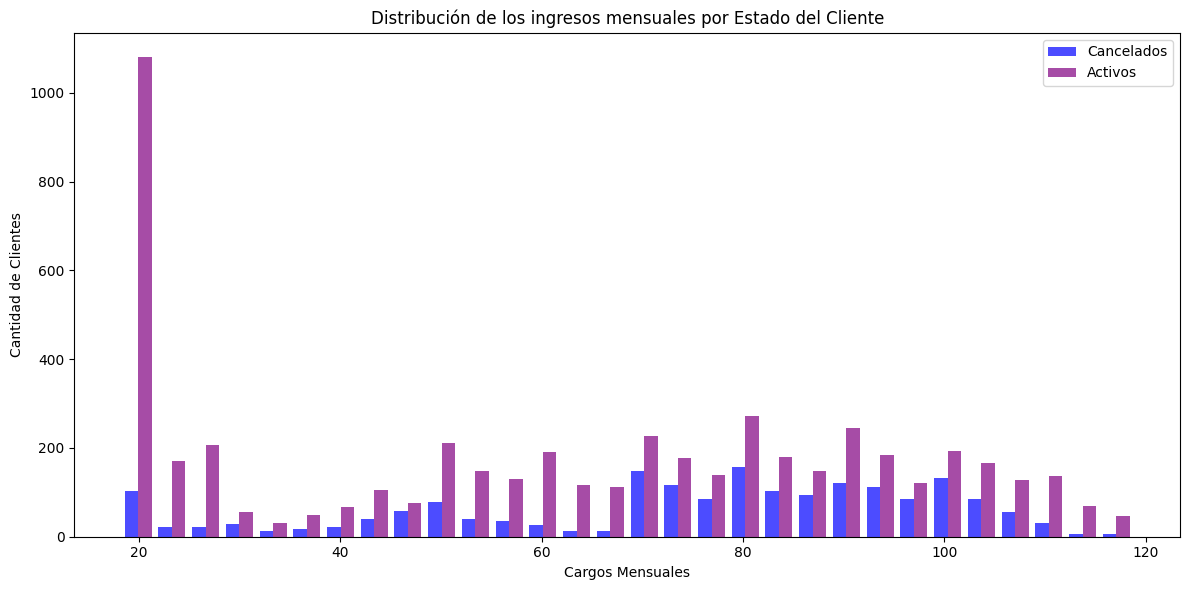

In [124]:
# Caunto era el ingresos mensuales para la empresa de los clientes que se fueron versus los clientres que aun mantienen el servicio 
cancelados = contrato[contrato['Churn'] == 1]['MonthlyCharges']
activos = contrato[contrato['Churn'] == 0]['MonthlyCharges']

# Crear histograma comparativo
plt.figure(figsize=(12, 6))
plt.hist([cancelados, activos], bins=30, label=['Cancelados', 'Activos'], color=['blue', 'purple'], alpha=0.7)

# Títulos y etiquetas
plt.title('Distribución de los ingresos mensuales por Estado del Cliente')
plt.xlabel('Cargos Mensuales')
plt.ylabel('Cantidad de Clientes')
plt.legend()
plt.tight_layout()
plt.show()


### Observaciones
Los clientes que que cancelaron ingresaban menos dinero a la empresa mes a mes que los que se mantienen activos esto igual esta relacionado al tipo de contrato que tenian en su mayoria. 

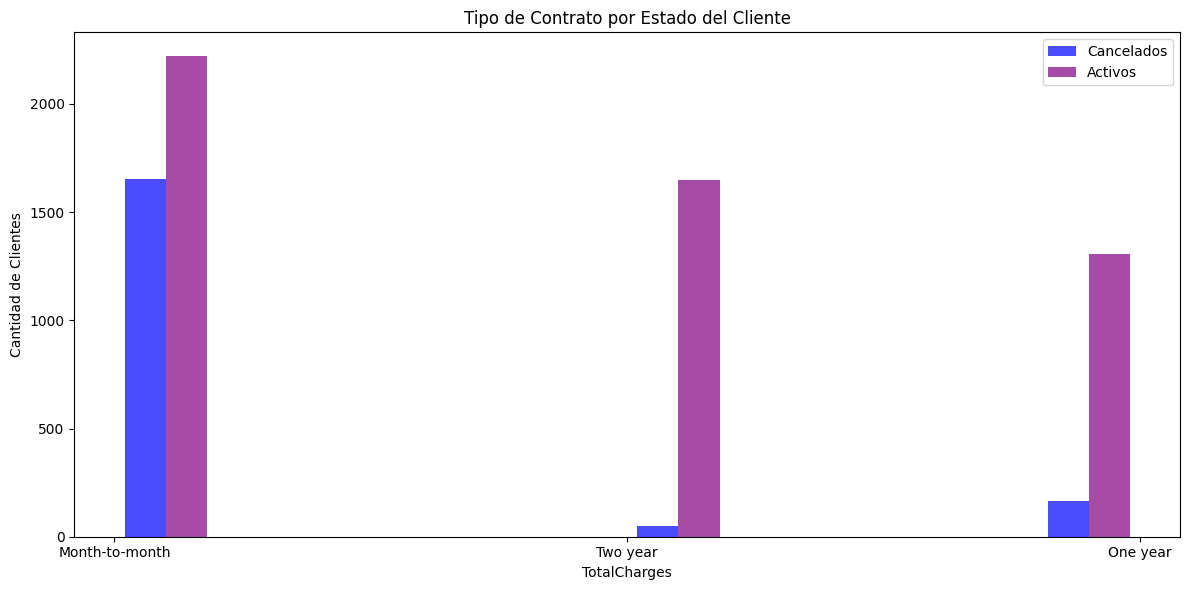

In [125]:
# Que tipo de contrato tenian los clientes que cancelaron versus los activos 
cancelados = contrato[contrato['Churn'] == 1]['Type']
activos = contrato[contrato['Churn'] == 0]['Type']

# Crear histograma comparativo
plt.figure(figsize=(12, 6))
plt.hist([cancelados, activos], bins=10, label=['Cancelados', 'Activos'], color=['blue', 'purple'], alpha=0.7)

# Títulos y etiquetas
plt.title('Tipo de Contrato por Estado del Cliente')
plt.xlabel('TotalCharges')
plt.ylabel('Cantidad de Clientes')
plt.legend()
plt.tight_layout()
plt.show()


### Observaciones
Como se visualizo en la grafica anterior efectivamente el tipo de contrato de los clientes que cancelaron en su mayoria tenian un contrato mes a mes. 

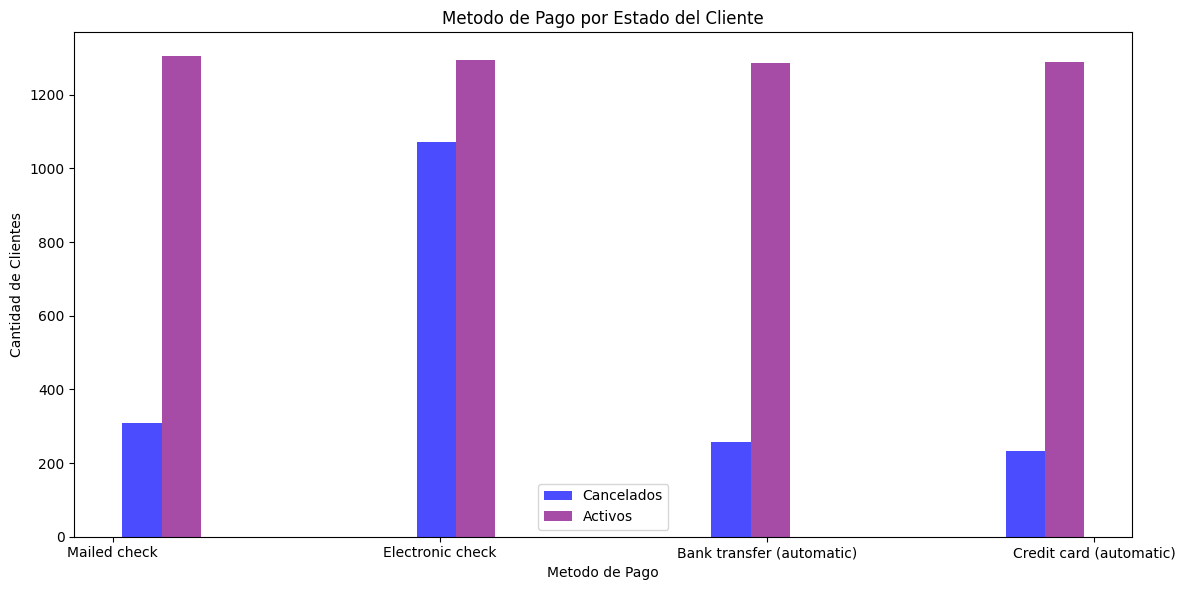

In [126]:
# Que metodo de pago tenian los clientes que cancelaron versus los activos 
cancelados = contrato[contrato['Churn'] == 1]['PaymentMethod']
activos = contrato[contrato['Churn'] == 0]['PaymentMethod']

# Crear histograma comparativo
plt.figure(figsize=(12, 6))
plt.hist([cancelados, activos], bins=10, label=['Cancelados', 'Activos'], color=['blue', 'purple'], alpha=0.7)

# Títulos y etiquetas
plt.title('Metodo de Pago por Estado del Cliente')
plt.xlabel('Metodo de Pago')
plt.ylabel('Cantidad de Clientes')
plt.legend()
plt.tight_layout()
plt.show()


### Observaciones
La mayoria clientes que cancelaron usaban mas pago electronico que el resto se metodos de pago.

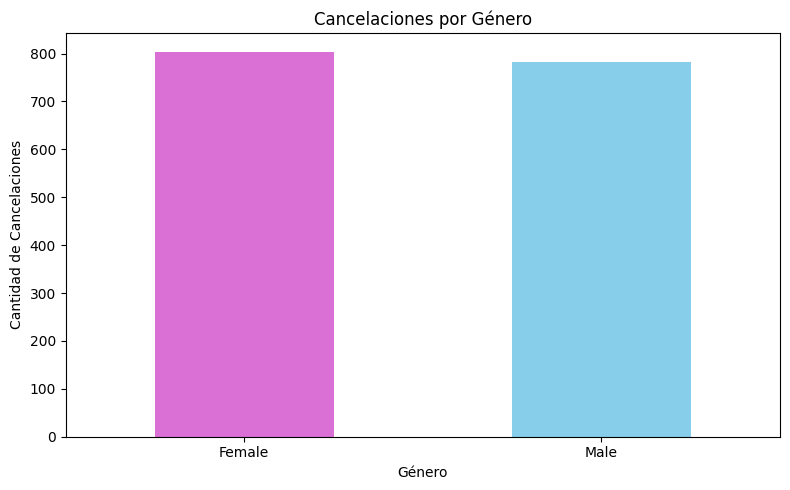

In [127]:
# Filtrar solo los que cancelaron
cancelados = df_final[df_final['Churn'] == 1]

# Contar cuántos hombres y mujeres hay entre los cancelados
conteo_genero = cancelados['Gender'].value_counts()

# Graficar como barras
plt.figure(figsize=(8, 5))
conteo_genero.plot(kind='bar', color=['orchid', 'skyblue'])

plt.title('Cancelaciones por Género')
plt.xlabel('Género')
plt.ylabel('Cantidad de Cancelaciones')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Observaciones
En la siguiente grafica se puede visualizar que estan balanceadas las clases de los clientes por genero que cancelaron es minimo la cantidad por la que las mujeres superan a los hombres. 

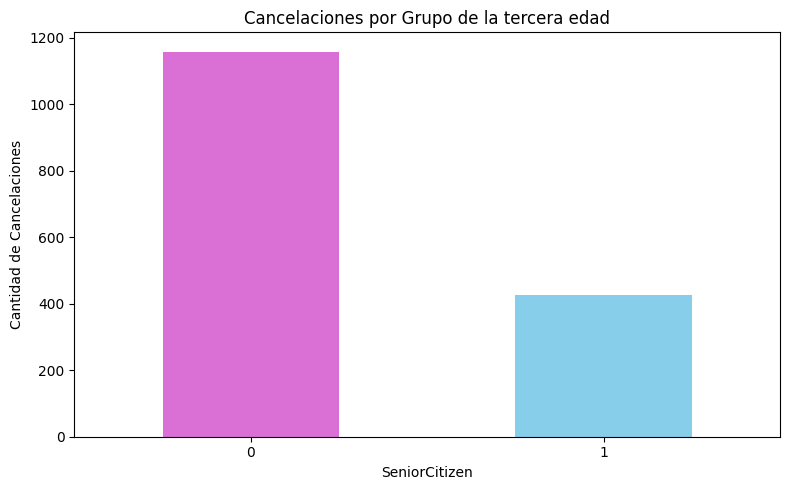

In [128]:
# Los clientes que cancelaron en su mayoria eran de la Tercer Edad
# Filtrar solo los que cancelaron
cancelados = df_final[df_final['Churn'] == 1]

# Contar usarios que cancelaron son de tercera edad 
conteo_tercera_edad = cancelados['SeniorCitizen'].value_counts()

# Graficar como barras
plt.figure(figsize=(8, 5))
conteo_tercera_edad.plot(kind='bar', color=['orchid', 'skyblue'])

plt.title('Cancelaciones por Grupo de la tercera edad')
plt.xlabel('SeniorCitizen')
plt.ylabel('Cantidad de Cancelaciones')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Observaciones
La mayoria de clientes que cancelaron no eran de la tercera edad. 

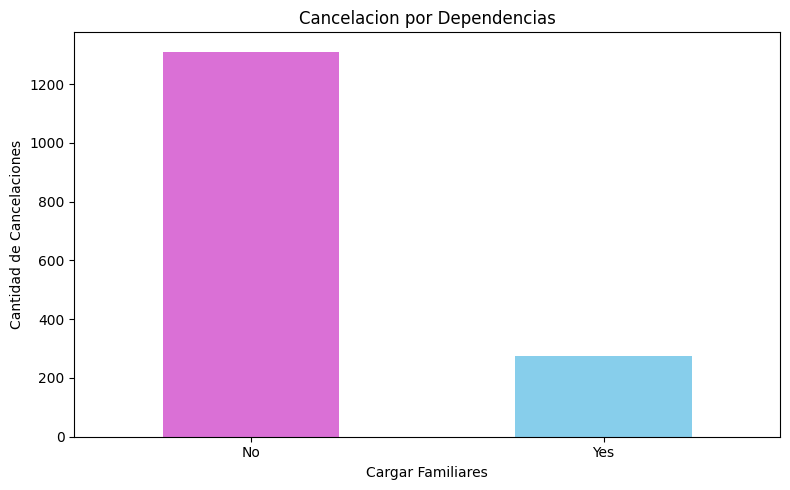

In [129]:
# Los clientes que cancelaron en su mayoria tenian Cargas familiares
# Filtrar solo los que cancelaron
cancelados = df_final[df_final['Churn'] == 1 ]

# Contar cuántos hombres y mujeres hay entre los cancelados
conteo_dependents = cancelados['Dependents'].value_counts()

# Graficar como barras
plt.figure(figsize=(8, 5))
conteo_dependents.plot(kind='bar', color=['orchid', 'skyblue'])

plt.title('Cancelacion por Dependencias')
plt.xlabel('Cargar Familiares')
plt.ylabel('Cantidad de Cancelaciones')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Observaciones 
La mayoria de clientes que cancelaron no tenian cargas familiares.

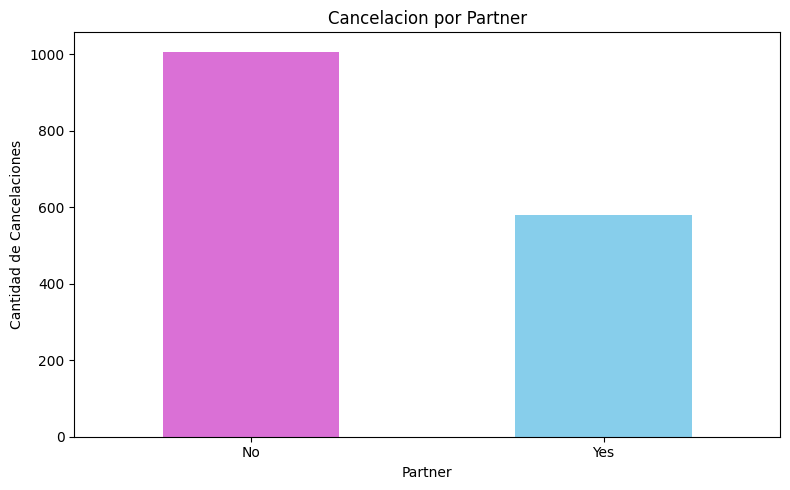

In [130]:
# Los clientes que cancelaron en su mayoria tenian Partner
# Filtrar solo los que cancelaron
cancelados = df_final[df_final['Churn'] == 1]

# Contar cuántos hombres y mujeres hay entre los cancelados
partners = cancelados['Partner'].value_counts()

# Graficar como barras
plt.figure(figsize=(8, 5))
partners.plot(kind='bar', color=['orchid', 'skyblue'])

plt.title('Cancelacion por Partner')
plt.xlabel('Partner')
plt.ylabel('Cantidad de Cancelaciones')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Observaciones
La mayoria de usuarios que cancelaron no tenian Partners. 

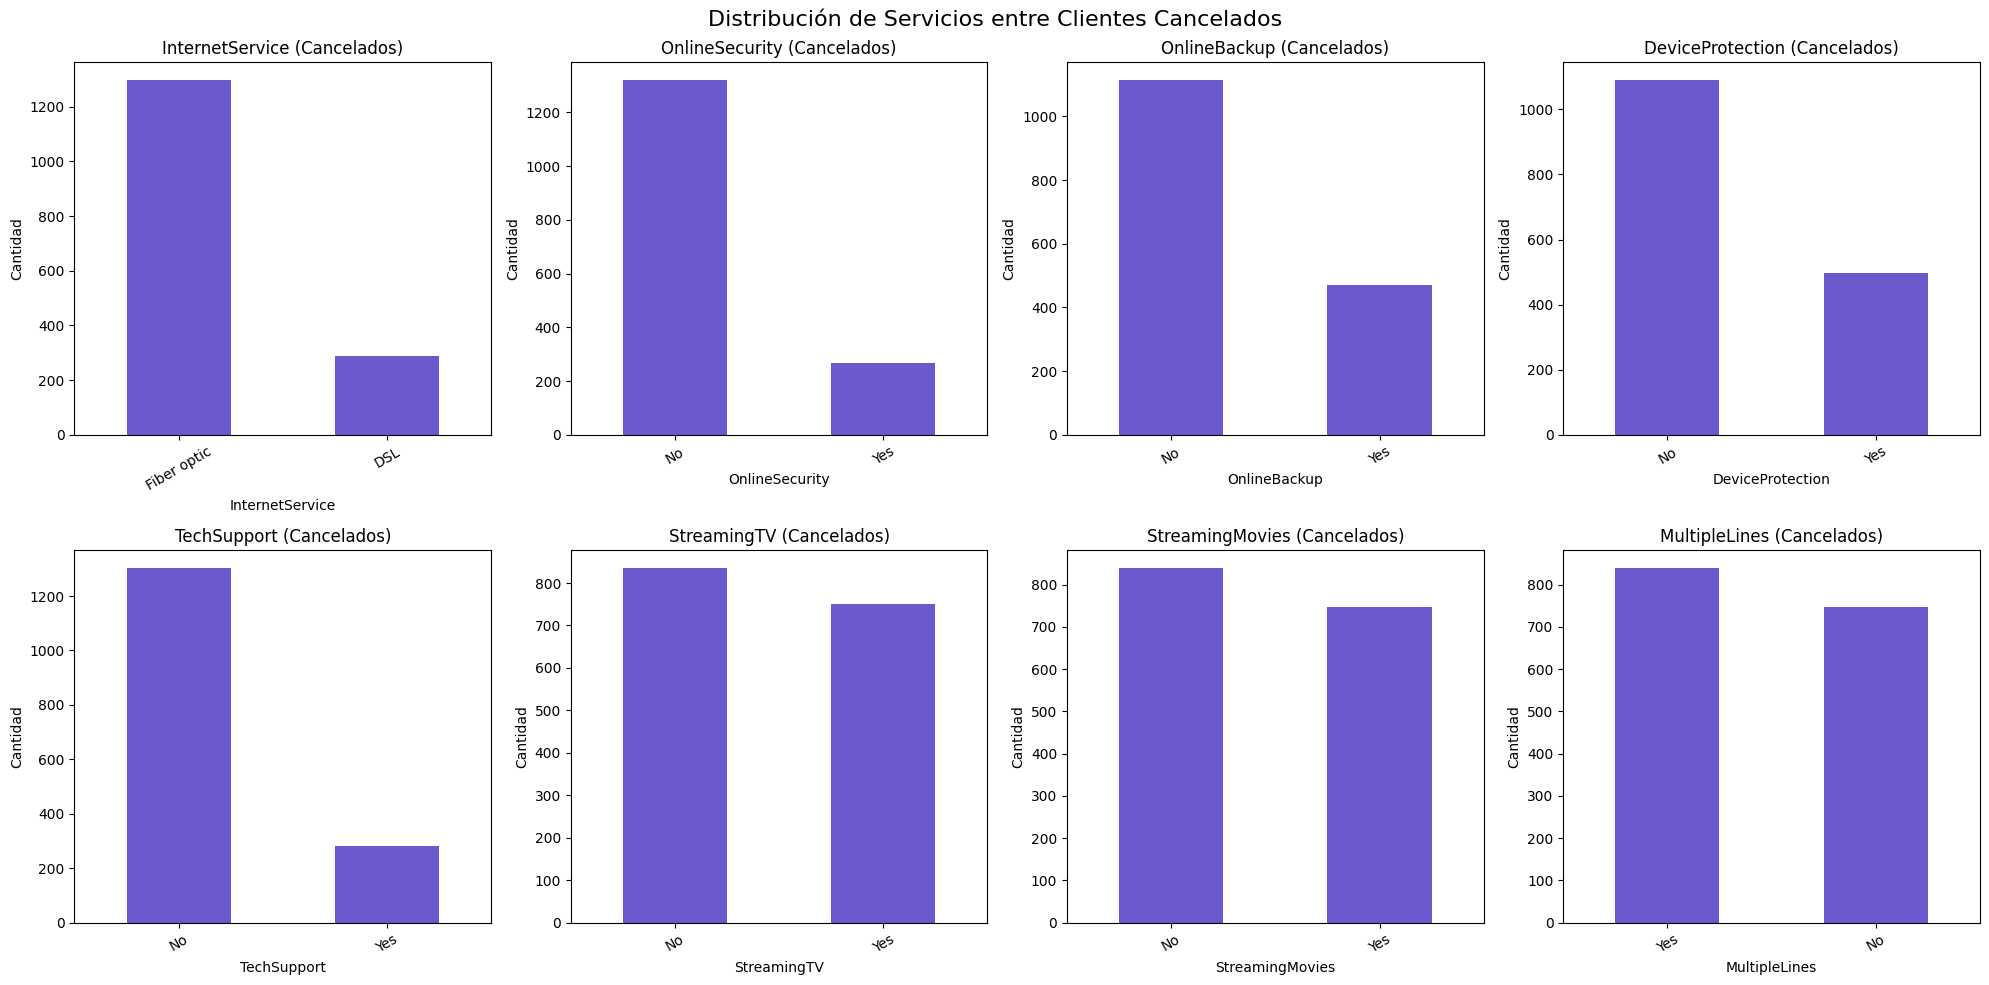

In [131]:
# Que servicios de telefonia e internet tenian los clientes que cancelaron.
# Filtrar clientes cancelados
cancelados = df_final[df_final['Churn'] == 1]

# Lista de servicios tecnológicos que quieres graficar
servicios = [
    'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV',
    'StreamingMovies', 'MultipleLines'
]

# Crear gráficos
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.flatten()  # Para iterar fácilmente

for i, col in enumerate(servicios):
    cancelados[col].value_counts().plot(kind='bar', ax=axes[i], color='slateblue')
    axes[i].set_title(f'{col} (Cancelados)')
    axes[i].set_ylabel('Cantidad')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=30)

plt.suptitle('Distribución de Servicios entre Clientes Cancelados', fontsize=16)
plt.tight_layout()
plt.show()


### Observaciones
Se visualizar que los clientes que cancelaron tenian un servicio de Internet de fibra Optica en su mayoria, n contaban con la mayoria de servicios que incluyen seguridad, en los servicios de Stremming si estan balancelados los datos asi como en su mayoria de los clientes que cancelaron tenian mutiples lineas telefonicas. 

## Codificacion de Datos 

In [132]:
#Transformar columnas con datos binarios en datos enteros
binarias = ['Partner', 'Dependents', 'PaperlessBilling', 'OnlineSecurity',
            'OnlineBackup', 'DeviceProtection', 'TechSupport',
            'StreamingTV', 'StreamingMovies', 'MultipleLines']

for col in binarias:
    df_final[col] = df_final[col].map({'Yes': 1, 'No': 0})

In [133]:
data_codificada = pd.get_dummies(df_final, columns=['Type','PaymentMethod','Gender','InternetService'], drop_first=True)

In [134]:
bool_cols = data_codificada.select_dtypes(include='bool').columns

for col in bool_cols:
    data_codificada[col] = data_codificada[col].astype(int)

In [135]:
data_codificada

,customerID,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,duracion_meses,SeniorCitizen,Partner,Dependents,OnlineSecurity,...,StreamingTV,StreamingMovies,MultipleLines,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Gender_Male,InternetService_Fiber optic
0,5575-GNVDE,0,56.95,1889.50,0,101,0,0,0,1,...,0,0,0,1,0,0,0,1,1,0
1,3668-QPYBK,1,53.85,108.15,1,2,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0
2,9237-HQITU,1,70.70,151.65,1,2,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,9305-CDSKC,1,99.65,820.50,1,8,0,0,0,0,...,1,1,1,0,0,0,1,0,0,1
4,1452-KIOVK,1,89.10,1949.40,0,89,0,0,1,0,...,1,0,1,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,8456-QDAVC,1,78.70,1495.10,0,86,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
4831,6840-RESVB,1,84.80,1990.50,0,91,0,1,1,1,...,1,1,1,1,0,0,0,1,1,0
4832,2234-XADUH,1,103.20,7362.90,0,139,0,1,1,0,...,1,1,1,1,0,1,0,0,0,1
4833,8361-LTMKD,1,74.40,306.60,1,4,1,1,0,0,...,0,0,1,0,0,0,0,1,1,1


In [136]:
data_codificada.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customerID                             4835 non-null   object 
 1   PaperlessBilling                       4835 non-null   int64  
 2   MonthlyCharges                         4835 non-null   float64
 3   TotalCharges                           4835 non-null   float64
 4   Churn                                  4835 non-null   int64  
 5   duracion_meses                         4835 non-null   int32  
 6   SeniorCitizen                          4835 non-null   int64  
 7   Partner                                4835 non-null   int64  
 8   Dependents                             4835 non-null   int64  
 9   OnlineSecurity                         4835 non-null   int64  
 10  OnlineBackup                           4835 non-null   int64  
 11  Devi

In [137]:
data_codificada

,customerID,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,duracion_meses,SeniorCitizen,Partner,Dependents,OnlineSecurity,...,StreamingTV,StreamingMovies,MultipleLines,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Gender_Male,InternetService_Fiber optic
0,5575-GNVDE,0,56.95,1889.50,0,101,0,0,0,1,...,0,0,0,1,0,0,0,1,1,0
1,3668-QPYBK,1,53.85,108.15,1,2,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0
2,9237-HQITU,1,70.70,151.65,1,2,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,9305-CDSKC,1,99.65,820.50,1,8,0,0,0,0,...,1,1,1,0,0,0,1,0,0,1
4,1452-KIOVK,1,89.10,1949.40,0,89,0,0,1,0,...,1,0,1,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,8456-QDAVC,1,78.70,1495.10,0,86,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
4831,6840-RESVB,1,84.80,1990.50,0,91,0,1,1,1,...,1,1,1,1,0,0,0,1,1,0
4832,2234-XADUH,1,103.20,7362.90,0,139,0,1,1,0,...,1,1,1,1,0,1,0,0,0,1
4833,8361-LTMKD,1,74.40,306.60,1,4,1,1,0,0,...,0,0,1,0,0,0,0,1,1,1


In [138]:
data_codificada = data_codificada.set_index('customerID')

In [139]:
data_codificada.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4835 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   PaperlessBilling                       4835 non-null   int64  
 1   MonthlyCharges                         4835 non-null   float64
 2   TotalCharges                           4835 non-null   float64
 3   Churn                                  4835 non-null   int64  
 4   duracion_meses                         4835 non-null   int32  
 5   SeniorCitizen                          4835 non-null   int64  
 6   Partner                                4835 non-null   int64  
 7   Dependents                             4835 non-null   int64  
 8   OnlineSecurity                         4835 non-null   int64  
 9   OnlineBackup                           4835 non-null   int64  
 10  DeviceProtection                       4835 non-null   int64  

## Segmentacion de Datos

In [140]:
# Dividir los datos en conjunto de entrenamiento, conjunto de validación, conjunto de prueba.
train_valid, test = train_test_split(data_codificada, test_size=0.2)
train, valid = train_test_split(train_valid, test_size=0.25)

In [141]:
#Separar los atributos de las caracteristicas
features_train = train.drop(columns=['Churn'], axis=1)
target_train = train['Churn']
features_valid = valid.drop(columns=['Churn'], axis=1)
target_valid = valid['Churn']
features_test = test.drop(columns=['Churn'], axis=1)
target_test = test['Churn']

In [142]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(2901, 21)
(967, 21)
(967, 21)


In [143]:
print(features_train.columns)

Index(['PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'duracion_meses',
       'SeniorCitizen', 'Partner', 'Dependents', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'MultipleLines', 'Type_One year', 'Type_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Gender_Male', 'InternetService_Fiber optic'],
      dtype='object')


In [147]:
#Funcion para escalar datos
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def escalar_datos(features_train, features_valid, features_test,
                  columnas_standard, columna_minmax):
    # Escalar con StandardScaler (media y desviación)
    scaler_std = StandardScaler()
    features_train[columnas_standard] = scaler_std.fit_transform(features_train[columnas_standard])
    features_valid[columnas_standard] = scaler_std.transform(features_valid[columnas_standard])
    features_test[columnas_standard] = scaler_std.transform(features_test[columnas_standard])
    
    # Escalar con MinMaxScaler (entre 0 y 1)
    scaler_mm = MinMaxScaler()
    features_train[columna_minmax + '_scaled'] = scaler_mm.fit_transform(features_train[[columna_minmax]])
    features_valid[columna_minmax + '_scaled'] = scaler_mm.transform(features_valid[[columna_minmax]])
    features_test[columna_minmax + '_scaled'] = scaler_mm.transform(features_test[[columna_minmax]])

    # Eliminar columna original si ya fue escalada
    features_train = features_train.drop(columns=[columna_minmax])
    features_valid = features_valid.drop(columns=[columna_minmax])
    features_test  = features_test.drop(columns=[columna_minmax])

    return features_train, features_valid, features_test


In [148]:
columns_standard = ['MonthlyCharges', 'TotalCharges']
columna_minmax = 'duracion_meses'

features_train, features_valid, features_test = escalar_datos(
    features_train, features_valid, features_test,
    columns_standard, columna_minmax
)

In [149]:
features_train

,PaperlessBilling,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,StreamingMovies,MultipleLines,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Gender_Male,InternetService_Fiber optic,duracion_meses_scaled
customerID,,,,,,,,,,,,,,,,,,,,,
4855-SNKMY,1,-2.051468,-1.189205,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0.000000
7109-MFBYV,0,-1.977603,-0.694678,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0.666667
0083-PIVIK,0,-0.018801,1.108004,0,0,0,1,1,1,1,...,0,1,1,0,0,1,0,1,0,0.942029
6384-VMJHP,1,-0.470201,0.982257,0,0,0,1,1,1,1,...,1,0,0,1,1,0,0,0,0,1.000000
9921-QFQUL,0,0.468163,-0.357049,0,1,0,0,0,1,0,...,1,1,0,0,0,0,1,0,1,0.644928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9992-RRAMN,1,0.191852,-0.428272,0,1,0,0,0,0,0,...,1,1,0,0,0,1,0,1,1,0.152174
7054-ENNGU,0,-1.682141,-1.013487,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0.543478
6877-TJMBR,1,0.175437,-1.172278,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,1,1,0.000000


<Axes: xlabel='Churn'>

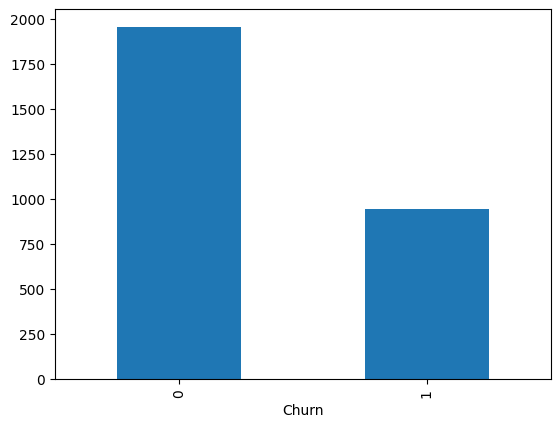

In [150]:
#Comprobar el balanceo de clases
target_train.value_counts().plot(kind='bar')

In [151]:
#Crear ejemplos sinteticos realista para balancear las clases
smote = SMOTE(random_state=42)
X_resample, y_resample = smote.fit_resample(features_train, target_train)


<Axes: title={'center': 'Distribución de clases balanceadas'}, xlabel='Churn'>

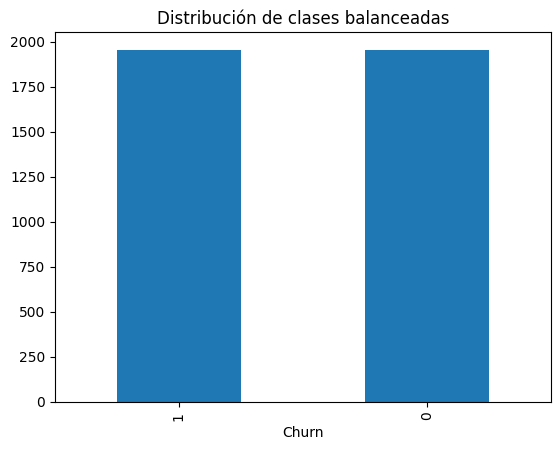

In [152]:
#Ver distribucion de clases balanceadas con SMOTE
pd.Series(y_resample).value_counts().plot(kind='bar', title='Distribución de clases balanceadas')

In [153]:
#Crear una funcion para el submuestreo
def submuestreo(caracteristicas, objetivo):
    # Separar clases
    caracteristicas_0 = caracteristicas[objetivo == 0]
    caracteristicas_1 = caracteristicas[objetivo == 1]
    objetivo_0 = objetivo[objetivo == 0]
    objetivo_1 = objetivo[objetivo == 1]

    # Recortar la clase mayoritaria (0) para que tenga el mismo tamaño que la clase 1
    n_min = len(objetivo_1)
    caracteristicas_0_sampled = caracteristicas_0.sample(n=n_min, random_state=12345)
    objetivo_0_sampled = objetivo_0.sample(n=n_min, random_state=12345)

    # Combinar ambos subconjuntos
    caracteristicas_sub = pd.concat([caracteristicas_0_sampled, caracteristicas_1])
    objetivo_sub = pd.concat([objetivo_0_sampled, objetivo_1])

    # Mezclar filas aleatoriamente
    return shuffle(caracteristicas_sub, objetivo_sub, random_state=12345)   

In [154]:
features_dowsample, target_dowsample = submuestreo(features_train, target_train) 

<Axes: xlabel='Churn'>

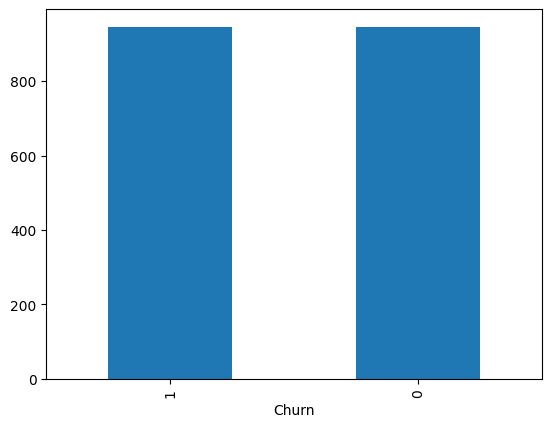

In [155]:
target_dowsample.value_counts().plot(kind='bar')

## Trabajar con modelos

### Modelo sin balancear

In [156]:
# Probar modelo sin balancear  
mejor_f1 = 0
mejor_auc_roc = 0
mejores_parametros_f1 = None
mejores_parametros_auc = None

for arboles in range(10, 101, 20):
    for ramas in range(1, 20, 5):
        modelo_bosque = RandomForestClassifier(n_estimators=arboles, max_depth=ramas, random_state=42)
        modelo_bosque.fit(features_train, target_train)
        prediccion_valid = modelo_bosque.predict(features_valid)
        probabilidades_valid = modelo_bosque.predict_proba(features_valid)[:, 1]

        # Métricas
        f1 = f1_score(target_valid, prediccion_valid)
        auc_roc = roc_auc_score(target_valid, probabilidades_valid)

        # Verificar si es el mejor puntaje
        if f1 > mejor_f1:
            mejor_f1 = f1
            mejores_parametros_f1 = {'Árboles': arboles, 'Ramas': ramas}
        if auc_roc > mejor_auc_roc:
            mejor_auc_roc = auc_roc
            mejores_parametros_auc = {'Árboles': arboles, 'Ramas': ramas}

print(f"Mejor F1-Score: {mejor_f1} con parámetros {mejores_parametros_f1}")
print(f"Mejor AUC-ROC: {mejor_auc_roc} con parámetros {mejores_parametros_auc}")

Mejor F1-Score: 0.9983579638752053 con parámetros {'Árboles': 90, 'Ramas': 16}
Mejor AUC-ROC: 1.0 con parámetros {'Árboles': 30, 'Ramas': 11}


In [157]:
#Probar modelo del Bosque con los mejores valores sin balanceo 
modelo_bosque_desbalanceado= RandomForestClassifier(n_estimators=90, max_depth=11)
modelo_bosque_desbalanceado.fit(features_train, target_train)

RandomForestClassifier(max_depth=11, n_estimators=90)

In [158]:
#Realizar las prediciones con el modelo sin balanceo 
prediccion_valid = modelo_bosque_desbalanceado.predict(features_test)
probabilidades_valid = modelo_bosque_desbalanceado.predict_proba(features_test)[:, 1]
#Evaluar el modelo 
print('Score del modelo sin balanceo')
print('Valid F1: ',f1_score(target_test, prediccion_valid))
print('Valid AUC-ROC:',roc_auc_score(target_test, probabilidades_valid))

Score del modelo sin balanceo
Valid F1:  0.9910179640718563
Valid AUC-ROC: 0.9999527678065369


In [190]:
from sklearn.metrics import confusion_matrix
target_pred = modelo.predict(features_valid)
print(confusion_matrix(target_valid, target_pred))

[[662   0]
 [  2 303]]


### Modelo con Sobreajuste

In [159]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score

mejor_f1 = 0
mejor_auc_roc = 0
mejores_parametros_f1 = None
mejores_parametros_auc = None

for arboles in range(10, 101, 20):
    for ramas in range(1, 20, 5):
        modelo_bosque = RandomForestClassifier(n_estimators=arboles, max_depth=ramas, random_state=42)
        modelo_bosque.fit(X_resample, y_resample)

        prediccion_valid = modelo_bosque.predict(X_resample)
        probabilidades_valid = modelo_bosque.predict_proba(X_resample)[:, 1]

        # Métricas
        f1 = f1_score(y_resample, prediccion_valid)
        auc_roc = roc_auc_score(y_resample, probabilidades_valid)

        # Verificar si es el mejor puntaje
        if f1 > mejor_f1:
            mejor_f1 = f1
            mejores_parametros_f1 = {'Árboles': arboles, 'Ramas': ramas}
        if auc_roc > mejor_auc_roc:
            mejor_auc_roc = auc_roc
            mejores_parametros_auc = {'Árboles': arboles, 'Ramas': ramas}

print(f"Mejor F1-Score: {mejor_f1} con parámetros {mejores_parametros_f1}")
print(f"Mejor AUC-ROC: {mejor_auc_roc} con parámetros {mejores_parametros_auc}")

Mejor F1-Score: 1.0 con parámetros {'Árboles': 10, 'Ramas': 11}
Mejor AUC-ROC: 1.0 con parámetros {'Árboles': 10, 'Ramas': 11}


In [160]:
#Entrenar un modelo con sobreajuste SMOTE
modelo_bosque_smote = RandomForestClassifier(n_estimators=50, max_depth=16, random_state=42)
modelo_bosque_smote.fit(X_resample, y_resample)

RandomForestClassifier(max_depth=16, n_estimators=50, random_state=42)

In [196]:
#Realizar las prediciones con el modelo sobreajustado
prediccion_valid_smote = modelo_bosque_smote.predict(features_test)
probabilidades_valid_smote = modelo_bosque_smote.predict_proba(features_test)[:, 1]
#Evaluar el modelo 
print('Score del modelo con sobremuestreo')
print('Valid F1: ',f1_score(target_test, prediccion_valid_smote))
print('Valid AUC-ROC:',roc_auc_score(target_test, probabilidades_valid_smote))

Score del modelo con sobremuestreo
Valid F1:  0.9955290611028316
Valid AUC-ROC: 0.9999574910258833


### Modelo Balanceado con Subajuste

In [162]:
### Modelo de balanceado con subajuste
mejor_f1 = 0
mejor_auc_roc = 0
mejores_parametros_f1 = None
mejores_parametros_auc = None

for arboles in range(10, 101, 20):
    for ramas in range(1, 20, 5):
        modelo_bosque = RandomForestClassifier(n_estimators=arboles, max_depth=ramas, random_state=42)
        modelo_bosque.fit(features_dowsample, target_dowsample)
        prediccion_valid = modelo_bosque.predict(features_dowsample)
        probabilidades_valid = modelo_bosque.predict_proba(features_dowsample)[:, 1]

        # Métricas
        f1 = f1_score(target_dowsample, prediccion_valid)
        auc_roc = roc_auc_score(target_dowsample, probabilidades_valid)

        # Verificar si es el mejor puntaje
        if f1 > mejor_f1:
            mejor_f1 = f1
            mejores_parametros_f1 = {'Árboles': arboles, 'Ramas': ramas}
        if auc_roc > mejor_auc_roc:
            mejor_auc_roc = auc_roc
            mejores_parametros_auc = {'Árboles': arboles, 'Ramas': ramas}

print(f"Mejor F1-Score: {mejor_f1} con parámetros {mejores_parametros_f1}")
print(f"Mejor AUC-ROC: {mejor_auc_roc} con parámetros {mejores_parametros_auc}")

Mejor F1-Score: 1.0 con parámetros {'Árboles': 10, 'Ramas': 11}
Mejor AUC-ROC: 1.0 con parámetros {'Árboles': 10, 'Ramas': 11}


In [163]:
#Entrenar el modelo del Bosque con los mejores valores con subajuste
modelo_bosque_subajustado= RandomForestClassifier(n_estimators=90, max_depth=16, class_weight='balanced')
modelo_bosque_subajustado.fit(features_dowsample, target_dowsample)

RandomForestClassifier(class_weight='balanced', max_depth=16, n_estimators=90)

In [164]:
#Realizar las prediciones con el modelo subajustado 
prediccion_valid = modelo_bosque_subajustado.predict(features_test)
probabilidades_valid = modelo_bosque_subajustado.predict_proba(features_test)[:, 1]
#Evaluar el modelo 
print('Score del modelo con submuestreo')
print('Valid F1: ',f1_score(target_test, prediccion_valid))
print('Valid AUC-ROC:',roc_auc_score(target_test, probabilidades_valid))

Score del modelo con submuestreo
Valid F1:  0.9955156950672646
Valid AUC-ROC: 0.9999763839032685


### Observaciones
El modelo subajustado tiene la mejor AUROC pero con menos datos.

### Modelo Regresion Logistica

In [169]:
model_regresion =LogisticRegression(class_weight='balanced', random_state=42)
model_regresion.fit(features_train, target_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [192]:
#Realizar predicciones
predictions = model_regresion.predict(features_valid)
probabilidades_valid = model_regresion.predict_proba(features_test)[:, 1]
#Evaluar el modelo 
print('Score del modelo de regresion logistica')
print('Valid F1: ',f1_score(target_test, predictions))
print('Valid AUC-ROC:',roc_auc_score(target_test, probabilidades_valid))

Score del modelo de regresion logistica
Valid F1:  0.33125
Valid AUC-ROC: 1.0


### Observaciones
El modelo de Regresion Logistica tiene una buena puntuacion del AUC-ROC, pero no equilibra bien la precision y el recall. 

## Seleccion del Mejor Modelo

Se selecciono el modelo que no se encuentra balanceado porque aunque el sobremostreo con SMOTE era eficiente al igual que el submustreo, sin balanceo igual tiene un buena tasa de predccion de los usaruios que van a cancelar se va graficar la curva AUC ROC para visualizarlo.

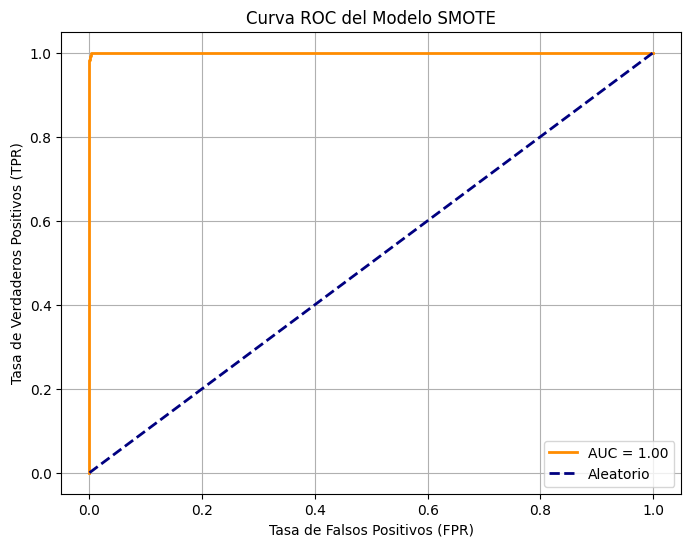

In [197]:
# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(target_test, probabilidades_valid_smote)
roc_auc = auc(fpr, tpr)

# Graficar
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC del Modelo SMOTE')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


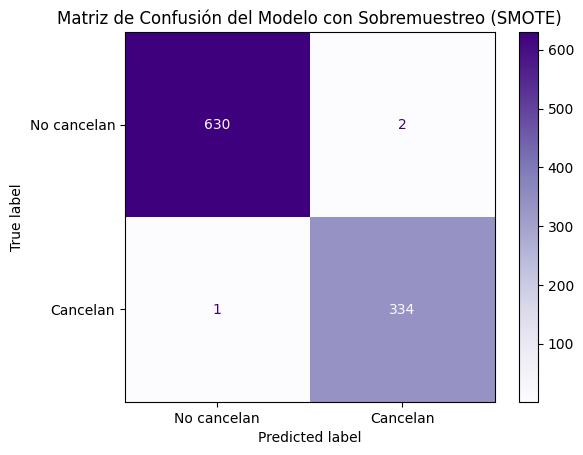

<Figure size 640x480 with 0 Axes>

In [201]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generar la matriz y graficarla
ConfusionMatrixDisplay.from_predictions(
    target_test,
    prediccion_valid_smote,
    display_labels=["No cancelan", "Cancelan"],
    cmap="Purples",
    colorbar=True
)

plt.title("Matriz de Confusión del Modelo con Sobremuestreo (SMOTE)")
plt.grid(False)
plt.show()
plt.savefig("visualizaciones_churn_modelo/curva_roc_smote.png", dpi=300, bbox_inches='tight')


In [202]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, ConfusionMatrixDisplay

# Crear carpeta si no existe
carpeta = "visualizaciones_churn_modelo"
os.makedirs(carpeta, exist_ok=True)

# 1️⃣ Curva ROC
fpr, tpr, _ = roc_curve(target_test, probabilidades_valid_smote)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - SMOTE')
plt.grid(True)
plt.legend()
plt.savefig(f"{carpeta}/curva_roc_smote.png", dpi=300, bbox_inches='tight')
plt.close()

# 2️⃣ Matriz de Confusión
ConfusionMatrixDisplay.from_predictions(
    target_test,
    prediccion_valid_smote,
    display_labels=["No cancelan", "Cancelan"],
    cmap="Purples",
    colorbar=True
)
plt.title("Matriz de Confusión - SMOTE")
plt.grid(False)
plt.savefig(f"{carpeta}/matriz_confusion_smote.png", dpi=300, bbox_inches='tight')
plt.close()

# 3️⃣ Curva Precisión vs. Recall
precision, recall, _ = precision_recall_curve(target_test, probabilidades_valid_smote)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precisión vs. Recall - SMOTE')
plt.grid(True)
plt.savefig(f"{carpeta}/precision_recall_curve_smote.png", dpi=300, bbox_inches='tight')
plt.close()

# 4️⃣ F1-Score vs Umbral
umbrales = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
f1_scores = [f1_score(target_test, (probabilidades_valid_smote > u).astype(int)) for u in umbrales]

plt.figure(figsize=(8, 6))
plt.plot(umbrales, f1_scores, marker='o', color='green')
plt.xlabel('Umbral de decisión')
plt.ylabel('F1-Score')
plt.title('F1-Score según Umbral - SMOTE')
plt.grid(True)
plt.savefig(f"{carpeta}/f1_score_umbral_smote.png", dpi=300, bbox_inches='tight')
plt.close()

print("✅ Visualizaciones exportadas exitosamente en la carpeta:", carpeta)

✅ Visualizaciones exportadas exitosamente en la carpeta: visualizaciones_churn_modelo


### Observaciones
El modelo logro predicion en su mayoria los usuarios que si van a cancelar solo dos no logro predicir pero igual tiene una gran precision, como se visualiza en en la matriz de confunsion. 

## Conclusiones

- El ojetivo era predecir la columna EndDate pero en la Etapa de DataWranling se decidio que debido a que esta columna esta relacionada con la columna de BeginDate se creo una nueva columna llamada Churn para no rellenar esos datos de tipo fecha de los usuarios que cancelaron con un dato Tipo Boleano y conservar su estructura, de igual manera estas columnas no se usaron para el entrenamiento del modelo sino la nueva columna Churn la cual es el objetivo de predicion del modelo, el cual se analiso que era una tarea de clasificacion ya que el departamento de marketing solicito la tasa de cancelacion y no una tasa de cancelacion segmentada ahi podria ser una tarea de regresion. 

- El mejor modelo que se escogio para hacer las predicciones fue el modelo SMOTE ya que sobrepasa la metrica que el proyecto solicito de AUC-ROC, al analizar por medio de una matriz de confunsion es minimo el error.  